In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import math
from copy import copy
import os
from numpy.linalg import inv
from numpy import matmul as mx

In [2]:
df = pd.read_csv("articular_kp_0.5_alpha_0.5_beta_0.2_gamma_0.8_t_20.csv")
jerks = df["dddx"].values
accs = df["ddx"].values
vels = df["dx"].values
poss = df["x"].values

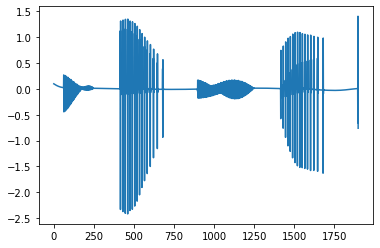

In [3]:
jerks = df["dddx"].values
plt.plot(jerks[100:])

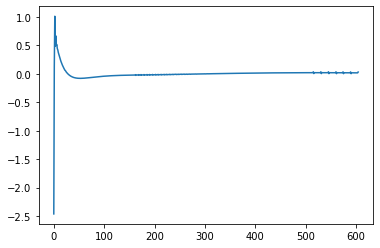

In [17]:
accs = df["ddx"].values
plt.plot(accs)

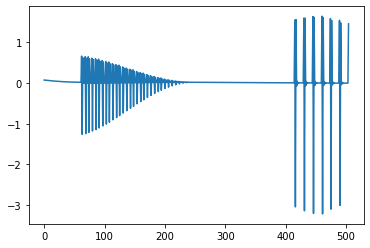

In [29]:
class KalmanDerivator:
    def __init__(self, deltaT):
        self.deltaT = deltaT
        
        self.x_k_k = np.zeros((4,1))
        self.x_k1_k = np.zeros((4,1))
        
        self.P_k_k =  np.eye(4)
        self.P_k1_k = np.eye(4)
        
        #self.K = np.zeros((4,2))    #np.random.randn(3,1)
        self.K = np.zeros((4,3)) 
        
        self.Q = 1*np.array([[deltaT**7/252, deltaT**6/72, deltaT**5/30, deltaT**4/24],
                            [deltaT**6/72, deltaT**5/30, deltaT**4/24, deltaT**3/6],
                            [deltaT**5/30, deltaT**4/24, deltaT**3/3, deltaT**2/2],
                            [deltaT**4/24, deltaT**3/6, deltaT**2/2, deltaT]]) #

                #2*np.diag([0.01,0.05,0.1])#
                #2.*np.eye(3)
                
        
        self.R = 0.001*np.eye(3)
        #self.R = 0.0005*np.eye(1)
        
        self.I = np.eye(4)

    def initialize(self, pos, vel, acc, jerk):
        self.x_k_k[0][0], self.x_k_k[1][0], self.x_k_k[2][0], self.x_k_k[3][0] = pos, vel, acc, jerk
        

    #def kalman_filter(self, pos, vel):
    def kalman_filter(self, pos, vel,acc):
        F = np.array([[1., self.deltaT, self.deltaT**2/2, self.deltaT**3/6],[0., 1., self.deltaT, self.deltaT**2/2],[0.,0.,1., self.deltaT],[0,0,0,1]])
        
        H = np.array([[1., 0., 0., 0],[0., 1., 0., 0],[0., 0., 1., 0]])
        #H = np.array([[0., 0., 1., 0]])

        z = np.array([[pos],[vel],[acc]])

        #Prediction
        self.x_k1_k = mx(F,self.x_k_k)
        self.P_k1_k = mx(F, mx(self.P_k_k, np.transpose(F))) +  self.Q

        #Update
        self.x_k_k = self.x_k1_k + mx(self.K, (z - mx(H, self.x_k1_k)))
        self.P_k_k = mx(mx((self.I - mx(self.K, H)), self.P_k1_k), np.transpose(self.I - mx(self.K, H))) + mx(self.K, mx(self.R, np.transpose(self.K))) 
        #self.P_k_k = mx(self.I - mx(self.K,H), self.P_k1_k)

        self.K = mx(mx(self.P_k1_k, np.transpose(H)), inv(mx(H, mx(self.P_k1_k, np.transpose(H))) + self.R))   
        
        return self.x_k_k[0][0], self.x_k_k[1][0], self.x_k_k[2][0], self.x_k_k[3][0]

In [30]:
kf = KalmanDerivator(0.01)
poss_est = []
vels_est = []
accs_est = []
jerks_est = []

pos0, vel0, acc0, jerk0 = poss[0], vels[0], accs[0], jerks[0] 
kf.initialize(pos0, vel0, acc0, jerk0)

for pos, vel, acc, jerk in zip(poss, vels, accs, jerks):
    pos_est, vel_est, acc_est, jerk_est = kf.kalman_filter(pos, vel, acc)
    poss_est.append(pos_est)
    vels_est.append(vel_est)
    accs_est.append(acc_est)
    jerks_est.append(jerk_est)

    

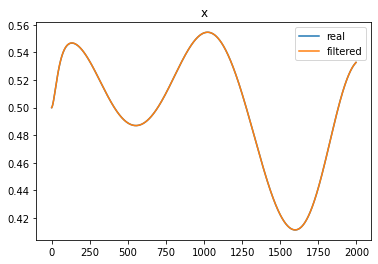

In [34]:
plt.plot(poss[1:])
plt.plot(poss_est[1:])
plt.title("x")
plt.legend(["real", "filtered"])

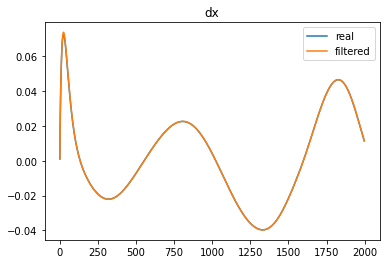

In [33]:
plt.plot(vels[1:])
plt.plot(vels_est[1:])
plt.title("dx")
plt.legend(["real", "filtered"])

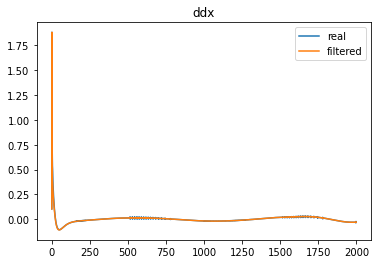

In [32]:
plt.plot(accs[1:])
plt.plot(accs_est[1:])
plt.title("ddx")
plt.legend(["real", "filtered"])

(-0.2, 0.2)

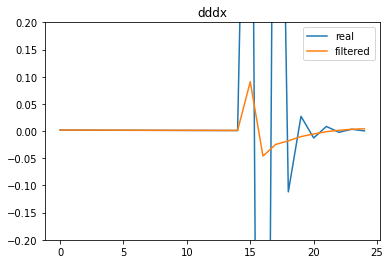

In [47]:
plt.plot(jerks[500:525])
plt.plot(jerks_est[500:525])
plt.title("dddx")
plt.legend(["real", "filtered"])
plt.ylim([-0.2,0.2])

In [40]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

(-0.2, 0.2)

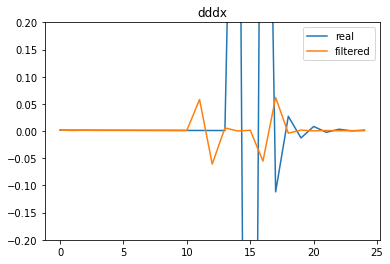

In [49]:
de = jerks[1:]
N = 20

de_est = running_mean(jerks, N)

plt.plot(de[500:525])
plt.plot(de_est[500:525])
plt.title("dddx")
plt.legend(["real", "filtered"])
plt.ylim([-0.2,0.2])